<a href="https://colab.research.google.com/github/samyzaf/notebooks/blob/main/bsm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div hidden>
$
\newcommand{\Dt}{\Delta t}
\newcommand{\Ds}{\Delta s}
\newcommand{\V}{\mathbf{V}}
$
</div>

# **Solving the Black-Scholes-Merton Formula by FDM**
<small>version: 26.12.2024a</small>

* **FDM** stands for **Finite Difference Method**.
* Hebrew readers can get more details on this project from the
  [**Course Project Booklet**](https://samyzaf.com/fdm/fdm.pdf).
* Thanks to
[Antoni Smolski](https://antonismolski.medium.com/?source=post_page-----965fd0539808--------------------------------)
for his inspiring BSM blog  
https://antonismolski.medium.com/implementation-of-black-scholes-formula-using-finite-difference-method-with-code-965fd0539808  
on which this notebook is based.

* Also many thanks to **QuantStart Newsletter** for a detailed
  outline of a **C++** code for an **Explicit Euler FDM** solution
  specific to the European call option equation at their blog  
  https://www.quantstart.com/articles/C-Explicit-Euler-Finite-Difference-Method-for-Black-Scholes/

* This notebook is part of a PDE course project at Israel
  Institute of Technology (Technion).
  Most of the theoretical background is explained
  in the project booklet (see the Moodle course page).

* The Python code in this notebook is essentially
  Antoni's Python code with
  needed modifications to suite our course needs and targets.

* The common **Black-Scholes-Merton equation** is the
  partial differential equation
  $$\large
  v_t +rsv_s + \frac{1}{2}\sigma^2 s^2 v_{ss} = r v
  $$
  which models the value of a financial derivative.

* For European Call Option, the equation is
  $$\large
  -v_t +rsv_s + \frac{1}{2}\sigma^2 s^2 v_{ss} = r v
  $$

* $v(s,t)$ is the option value of a given asset at
   price $s$,  at time $t$.

* $r$ = risk-free interest rate (aka **drift**)

* $\sigma$ = the price volatility measure of the stock
  (standard deviation of a
  [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution))

* We use Python's [Numpy package](https://numpy.org), to model
  the **FDM** grid structure which represents the discrete
  version of $v(s,t)$.

* We use our
  [**fdmtools Python package**](https://samyzaf.com/fdmtools.zip),
  which is installed and imported by the next code cell.
$
\newcommand{\Dt}{\Delta t}
\newcommand{\Ds}{\Delta s}
\newcommand{\V}{\mathbf{V}}
$

In [1]:
%pip install -q https://samyzaf.com/fdmtools.zip
from fdmtools.bsm import *

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
fdmtools version 5


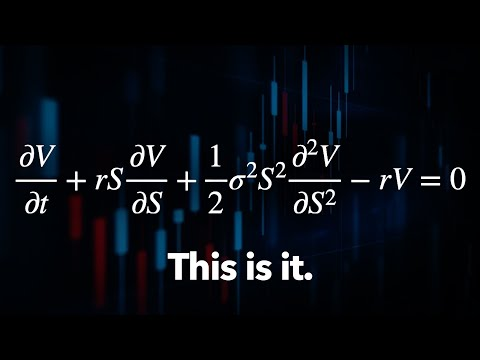

In [2]:
#@title Black-Scholes-Merton Equation Video
#@markdown  Motivation Video
YouTubeVideo("A5w-dEgIU1M", width=640, height=360)

* The implementation is the straightforward modification of
  Antoni Smolski code.

* I highly recommend reading his Blog!  
  https://antonismolski.medium.com/implementation-of-black-scholes-formula-using-finite-difference-method-with-code-965fd0539808  

* Another useful source:  
https://diter.medium.com/option-pricing-using-the-black-scholes-model-without-the-formula-e09235f75fb7

* The **FDM** solution is based on the following obsevations.
* First, the **BSM** equation can be written as   
  $$
  \large
  -v_t = rv - rsv_s - \frac{1}{2}\sigma^2 s^2 v_{ss}
  $$

* Let $\V$ be an **FDM** discrete grid model for the solution
  $v(s,t)$ of the **BSM** equation over a rectangular
  domain $[0,S]{\times}[0,T]$, where $S$ is the maximal
  asset price $s$, and $T$ is the maximal
  option maturation time $t$.

* The price interval $[0,S]$ is divided to discrete
  nodes $s_i = i\Ds$.
  The time interval $[0,T]$ is divided to time
  nodes $t_k = k\Dt$.
  The grid $\V$ models the solution $v(s,t)$ by
  $\V[i,k] = v(s_i,t_k)$.

* The FDM derivatives we need are as follows:

\begin{align*}
\V_s[i,k] &= \frac{\V[i+1,k] - \V[i-1,k]}{2\Ds}
\\[2.0ex]
\V_{ss}[i,k] &= \frac{\V[i+1,k] -2\V[i,k] + \V[i-1,k]}{\Ds^2}
\\[2.0ex]
\V_t[i,k] &= \frac{\V[i,k+1] - \V[i,k]}{\Dt}
\end{align*}

* From the first observation it follows that

$$
-\frac{\V[i,k+1] - \V[i,k]}{\Dt}
=
r \V[i,k] - rs\V_s[i,k] - \frac{1}{2}\sigma^2 s^2 \V_{ss}[i,k]
$$

* In our discrete model, $s=i\Ds$, and therefore  
  $$
  -\frac{\V[i,k+1] - \V[i,k]}{\Dt}
  =
  r \V[i,k] - r (i\Ds) \V_s[i,k] - \frac{1}{2}\sigma^2 (i\Ds)^2 \V_{ss}[i,k]
  $$

* From which we derive our recursive solution to the **BSM**
  equation:  
  $$
  \V[i,k+1]
  =
  \V[i,k] -
  \Dt \left(r \V[i,k] - r (i\Ds) \V_s[i,k] - \frac{1}{2}\sigma^2 (i\Ds)^2 \V_{ss}[i,k]\right)
  $$

* Many texts use the following abbreviation
$$
\gamma = r \V[i,k] - r (i\Ds) \V_s[i,k] + \frac{1}{2}\sigma^2 (i\Ds)^2 \V_{ss}[i,k]
$$
So we get a shorter form of this solution
$$
\V[i,k+1] = \V[i,k] + \gamma\Dt
$$

* If we implement $\V$ as a Python Numpy array, we can write
  a simple Python procedure for implementing this solution
  in Python.

In [3]:
# sigma = the volatility of the stock (standard deviation)
#         (the degree of variation of a trading price series over time)
# r = risk-free interest rate
# K = Strike price
# Ns = Number of asset price steps
# Nt = Number of time steps (Nt=0 means choose optimal number)

def Solve(sigma, r, K, T, Ns, Nt=0):
    S = 3*K                             # Max asset price
    ds = S/Ns                           # asset price step
    if Nt==0:                           # Automatic optimal selection of time step
        dt = 0.9 / (sigma**2 * Ns**2)   # Stable optimal value of dt
        Nt = int(T/dt) + 1              # Number of time steps
    dt = T/Nt                           # Ensure that T is an integer number of time steps away
    V = np.zeros((Ns+1, Nt+1))          # Option Value Array (V FDM grid)

    for i in range(Ns+1):
        V[i,0] = max(i*ds - K, 0)       # Initial condition at time t=0

    for k in range(0, Nt+1):            # Time loop
        V[0,k] = 0                      # Boundary condition at s=0
        V[Ns,k] = S - K*exp(-r*k*dt)    # Boundary condition at s=S (Smax)

    for k in range(0, Nt):      # Time loop
        # And now ... Nobel prize winning diff equation ;)
        for i in range(1, Ns):  # Asset loop
            Vs = (V[i+1,k] - V[i-1,k]) / (2*ds)               # Vs[i,k] as central difference
            Vss = (V[i+1,k] - 2*V[i,k] + V[i-1,k]) / (ds**2)  # Vss[i,k] as central difference
            gamma = r*V[i,k] - r*(i*ds) * Vs - 0.5 * sigma**2 * (i*ds)**2 * Vss
            V[i,k+1] = V[i,k] - gamma * dt

    asset_steps = ds * np.arange(0, Ns+1)   # Asset price steps from 0 to S (i*ds, i=0,1,..,Ns)
    time_steps = dt * np.arange(0, Nt+1)    # Time steps from 0 to T (k*dt, k=0,1,..,Nt)
    rounded_asset_steps = np.round(asset_steps, decimals=3)
    rounded_time_steps = np.round(time_steps, decimals=4)
    data = pd.DataFrame(np.transpose(V), index=rounded_time_steps, columns=rounded_asset_steps).round(3)
    data.attrs = dict(S=S, T=T, K=K, ds=ds, dt=dt, r=r, sigma=sigma, Ns=Ns, Nt=Nt)
    return data  # Output array as pandas data frame object

* The boundary conditions are explained in our
  [project booklet](https://samyzaf.com/fdm/fdm.pdf).

# A Simple Example
* In the following example we solve the **BSM** equation
  for a stock call option
  with the following parameters.

* We would like to find the value of an option on a stock
  which is currently priced **s=50**, for an equal
  strike price **K=50**, for maturation time **t=2** (2 years).

* In other words: the current price stock is 50$, and we would
  like to buy an option to purchase it again in 2 years for
  the same price (K=50).
  
* This option should cost us some money. The question is how much?

In [4]:
K = 50            # Option strike price
S = 3*K           # Maximum asset price
T = 3             # Maximum time (in year units)
Ns = 100          # number of asset price steps
Nt = 0            # Let Solve choose an optimal number of time steps
sigma = 0.4       # Asset price sensitivity (aka volatility)
r = 0.05          # Interest rate

data = Solve(sigma, r, K, T, Ns, Nt)   # We solve the BSM equation!

* **data** is a [Pandas](https://pandas.pydata.org/)
  [DataFrame object](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)
  which holds the FDM grid solution in a tabular form.

* This is a very useful information container which is
  easy to query. It supports more than 400 query types!

* Here are the first 5 rows of this table followed
  by the last 5 rows.
  
* The columns (keys) are asset price steps,
  and the lines are time steps.

* The simplest query is the **data** command itself which
  prints a small sample of of the table, which gives us
  a rough impression about the data it holds.

In [5]:
data

,0.0,1.5,3.0,4.5,6.0,7.5,9.0,10.5,12.0,13.5,...,136.5,138.0,139.5,141.0,142.5,144.0,145.5,147.0,148.5,150.0
0.0000,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,86.500,88.000,89.500,91.000,92.500,94.000,95.500,97.000,98.500,100.000
0.0006,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,86.501,88.001,89.501,91.001,92.501,94.001,95.501,97.001,98.501,100.001
0.0011,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,86.503,88.003,89.503,91.003,92.503,94.003,95.503,97.003,98.503,100.003
0.0017,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,86.504,88.004,89.504,91.004,92.504,94.004,95.504,97.004,98.504,100.004
0.0022,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,86.506,88.006,89.506,91.006,92.506,94.006,95.506,97.006,98.506,100.006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.9978,0.0,0.0,0.0,0.002,0.007,0.023,0.054,0.108,0.192,0.311,...,93.930,95.376,96.822,98.269,99.716,101.164,102.612,104.061,105.510,106.960
2.9983,0.0,0.0,0.0,0.002,0.007,0.023,0.054,0.109,0.192,0.311,...,93.931,95.377,96.823,98.270,99.717,101.165,102.614,104.062,105.511,106.961
2.9989,0.0,0.0,0.0,0.002,0.007,0.023,0.054,0.109,0.192,0.311,...,93.933,95.378,96.824,98.271,99.719,101.166,102.615,104.064,105.513,106.962
2.9994,0.0,0.0,0.0,0.002,0.007,0.023,0.054,0.109,0.193,0.312,...,93.934,95.380,96.826,98.273,99.720,101.168,102.616,104.065,105.514,106.963


* In the first column (from the left) we see the
  table **Index**. These are our **Time Steps**.
* The first row is called the **table header**.
  These are our **Price Steps**.

* On the right side of this table you will find three
  buttons for interacting with it just as if it was
  an Excel table.
  * The first button displays a full interactive table.
  * The second buttons display several charts, and
     can create code for generating them.
  * The third button is experimental AI code generator for
     extracting information from this table.

* To learn more on how you can interact with the
  **dataframe** object
  read the
  [Pandas package reference guide](https://pandas.pydata.org/docs/user_guide/index.html)

* For example, to print the table index (time steps),
  use the command:

In [6]:
times = data.index
print(times)

Index([   0.0, 0.0006, 0.0011, 0.0017, 0.0022, 0.0028, 0.0034, 0.0039, 0.0045,
       0.0051,
       ...
       2.9949, 2.9955, 2.9961, 2.9966, 2.9972, 2.9978, 2.9983, 2.9989, 2.9994,
          3.0],
      dtype='float64', length=5335)


* This is a list of 5335 time steps that are required for
  precision.
  
* To see the **table keys** (asset price steps),
  use the following command:

In [7]:
prices = data.keys()
print(prices)

Index([  0.0,   1.5,   3.0,   4.5,   6.0,   7.5,   9.0,  10.5,  12.0,  13.5,
       ...
       136.5, 138.0, 139.5, 141.0, 142.5, 144.0, 145.5, 147.0, 148.5, 150.0],
      dtype='float64', length=101)


* This is a list of 100 price steps with **ds=1.5**.
* Only a small sample is printed: the first 10 items, and
  the last 10 items.
* A Pandas **DataFrame** can be also exported into a
  Microsoft Excel sheet easily!
* If you are a Microsoft Excel user, you may want to convert
  it to an Excel sheet, and then interact with it using
  Microsoft office analysis tools.

In [8]:
data.to_excel("data.xlsx")

* The resulting Excel file can be viewed
  [from this link](https://samyzaf.com/fdm/data.xlsx)

* But you can download this Excel sheet from here to your
  local disk by the following command.

In [ ]:
file_download("data.xlsx")

* There are 427 methods that you can
  apply on a **DataFrame** object.

* To learn and try more of them check out the
  [DataFrame reference guide](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html).

# BSM Heatmap
* Use the **bsm_heatmap** for visualizing the **data**
  table as a heat map.

* This method is part of our
  [**fdmtools package**](https://samyzaf.com/fdmtools.zip)
  and can be viewed by downloading this package.

Max=0.0        0.000
1.5        0.000
3.0        0.000
4.5        0.002
6.0        0.007
          ...   
144.0    101.169
145.5    102.617
147.0    104.066
148.5    105.515
150.0    106.965
Length: 101, dtype: float64


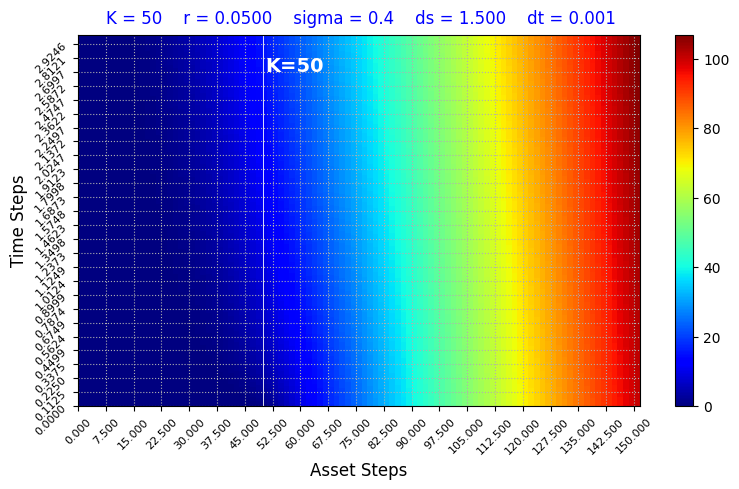

In [9]:
bsm_heatmap(data)

# BSM 3D surface representation
* There are more visualization aids available in Python's
  matplotlib package.

* Here is a 3D surface visualization of our **data** table.

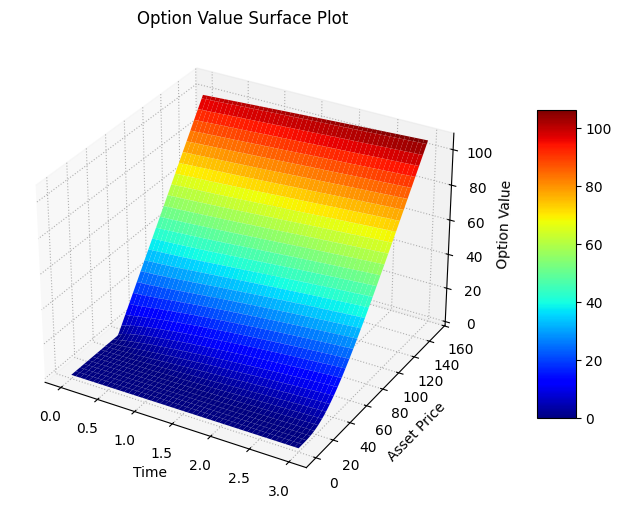

In [10]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
Y,X = np.meshgrid(data.columns, data.index)
Z = data.values
surf = ax.plot_surface(X, Y, Z, cmap="jet")
ax.set_xlabel('Time')
ax.set_ylabel('Asset Price')
ax.set_zlabel('Option Value')
ax.set_title('Option Value Surface Plot')
fig.colorbar(surf, shrink=0.5, aspect=8, pad=0.1)
plt.show()

# Extracting local and precision information
* The **data** object is quite large: 855 rows × 101 columns.
  That is 86355 entries!

* The heatmap and 3D surface plots are great **infographics**
  tools, but are not adequate for obtaining precise values
  for specific needs.

* In most cases we would like to inspect a small
  subset of information
  around specific values such as our strike price **K** and
  maturation time **t**.

* For example, if our strike price is **K=50** and maturation
  time is **t=60/365** (2 months), here is a small code snippet
  for extracting a small table around these values:

In [11]:
s = 50  # initial stock price and also our strike price
t = 60/365   # Maturation time (60 days)
ds = data.attrs["ds"]
dt = data.attrs["dt"]
i = int(s/ds)
k = int(t/dt)
print(f"Extracting a small sub-table (10x10) around price s={s} and time t={t}")
df = data.iloc[k-5:k+5, i-5:i+5]
df

Extracting a small sub-table (10x10) around price s=50 and time t=0.1643835616438356


,42.0,43.5,45.0,46.5,48.0,49.5,51.0,52.5,54.0,55.5
0.1614,0.572,0.871,1.267,1.772,2.390,3.124,3.971,4.923,5.972,7.107
0.1620,0.575,0.875,1.272,1.777,2.396,3.130,3.977,4.929,5.978,7.113
0.1625,0.578,0.879,1.277,1.782,2.402,3.137,3.983,4.935,5.984,7.118
0.1631,0.581,0.882,1.281,1.788,2.408,3.143,3.989,4.942,5.990,7.124
0.1637,0.584,0.886,1.286,1.793,2.414,3.149,3.996,4.948,5.996,7.130
0.1642,0.587,0.890,1.291,1.799,2.420,3.155,4.002,4.954,6.002,7.135
0.1648,0.591,0.894,1.295,1.804,2.425,3.161,4.008,4.960,6.008,7.141
0.1654,0.594,0.898,1.300,1.809,2.431,3.167,4.014,4.966,6.014,7.146
0.1659,0.597,0.902,1.305,1.815,2.437,3.173,4.021,4.972,6.020,7.152
0.1665,0.600,0.906,1.310,1.820,2.443,3.179,4.027,4.978,6.025,7.157


* Notice the **Next steps** suggestions at the bottom of
  the table which offers you code for generating plots.
  You can learn more by playing with it.
  
* The **data** object has a special attributes
  dictionary **data.attrs**
  which holds all the parameters: **S, K, T, ds, dt, ...**
  * To access the time step **dt** use:
    **dt = data.attrs["dt"]**.
  * To access the number of price steps **Ns** use:
    **Ns = data.attrs["Ns"]**.
  * Etc ...

* Like in Microsoft Excel, to access **data** we need integer
  indices **i**, **k**.
  Beware that **k** is a row index, and **i** is a column index!

* Therefore we had to convert the price value **s=50**
  to its corresponding column index **i=s/ds**,
  and the time value **t=60/365** to its corresponding
  row index **k=t/dt**.

* To access 10 rows around **i** we use a range expression
  **i-5:i+5**.

* But the first thing we should have noticed is that
  our desired price **s=50** and time **t=60/365=0.16438**
  are **not** in this table!

* This is a typical issue with discrete models, which is
  confronted by a special interpolation procedure for
  computing the in between values.

* Our **fdmtools** package includes an **interpolate** method
  for handling this issue

In [12]:
s = 50.0
t = 0.16438     # 60 days = 0.16438 of 1 year
v = interpolate(data, s, t)
print(v)

3.438939173333333


* So the value of a **CALL option** with price **s=50**
  and maturation time **t=2** years with
  a strike price **K=50** is **v=13.148**!
  This answers our initial problem.

* To make sure that your work is not detached from reality,
  it is recommended that you check if you get a similar result
  in an online option calculator (there are many of them
  on the internet).

* Here's is the result that we got from
  **https://www.barchart.com/options/options-calculator**

  <IMG src="https://samyzaf.com/fdm/opt_calc_ex2.jpg" width=640 align="center"/>

* Looks pretty close to what we got with our code: **v=3.4389**.

* We can also reconsider our maturation time to be **t=1.0**.
  We have a method for generating a local table around
  **s=50, t=1.0**.

* For that purpose we need a more general method for generating
  small subsets of our large table.
  For example, to generate a smaller table for price range 40-60
  and time range 0.98-1.02, we can use the following code:

In [13]:
times = [t for t in data.index if 0.98<=t<=1.02]
prices = [s for s in data.keys() if 40<=s<=60]
df = data.loc[times,prices]
df

,40.5,42.0,43.5,45.0,46.5,48.0,49.5,51.0,52.5,54.0,55.5,57.0,58.5,60.0
0.9803,3.920,4.573,5.278,6.036,6.845,7.701,8.604,9.550,10.538,11.565,12.629,13.727,14.858,16.018
0.9809,3.922,4.575,5.281,6.039,6.847,7.704,8.607,9.553,10.541,11.568,12.632,13.730,14.861,16.021
0.9814,3.925,4.577,5.283,6.042,6.850,7.707,8.609,9.556,10.544,11.571,12.635,13.733,14.863,16.024
0.9820,3.927,4.579,5.286,6.044,6.853,7.709,8.612,9.559,10.547,11.574,12.638,13.736,14.866,16.027
0.9826,3.929,4.582,5.288,6.047,6.855,7.712,8.615,9.562,10.550,11.577,12.641,13.739,14.869,16.029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.0174,4.062,4.723,5.437,6.202,7.016,7.878,8.785,9.735,10.725,11.754,12.818,13.917,15.047,16.206
1.0180,4.064,4.725,5.439,6.205,7.019,7.881,8.788,9.737,10.728,11.756,12.821,13.920,15.050,16.209
1.0186,4.066,4.728,5.442,6.207,7.022,7.883,8.790,9.740,10.731,11.759,12.824,13.923,15.053,16.212
1.0191,4.068,4.730,5.444,6.210,7.024,7.886,8.793,9.743,10.733,11.762,12.827,13.925,15.055,16.215


* This is still a long table (71 rows, 15 columns).
* We can use our heatmap or 3d surface tools to get
  a visual impression of it.

Max=40.5     4.071
42.0     4.732
43.5     5.447
45.0     6.212
46.5     7.027
48.0     7.889
49.5     8.796
51.0     9.746
52.5    10.736
54.0    11.765
55.5    12.830
57.0    13.928
58.5    15.058
60.0    16.218
dtype: float64


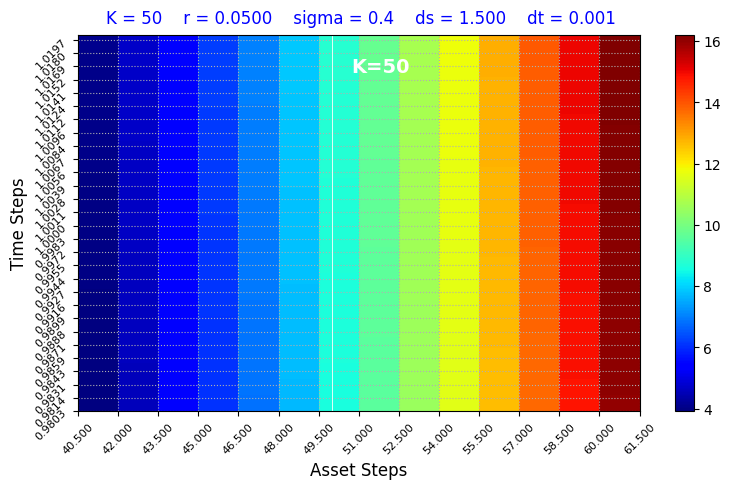

In [14]:
bsm_heatmap(df)

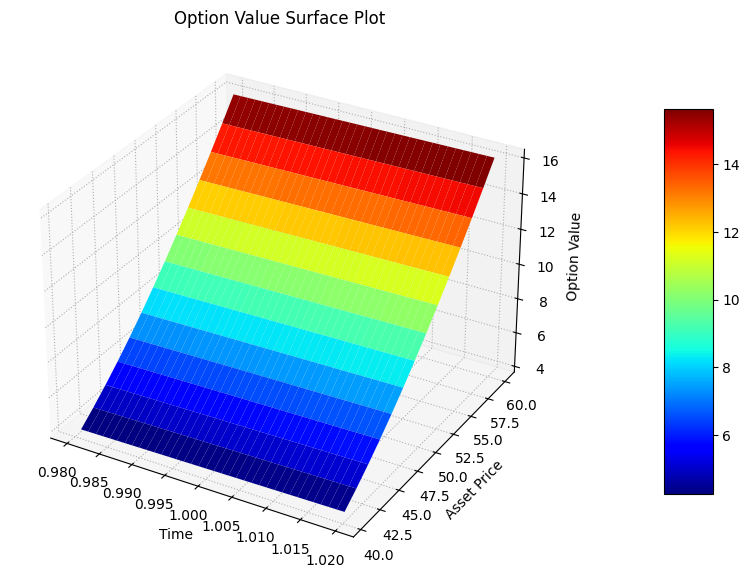

In [15]:
bsm_surface(df)

* We can perform more precise queries that collect data from
  several locations of our table.
* For example, we can include a small sample around t=1
  and a small sample around t=2.

In [16]:
times = [t for t in data.index if 0.99<=t<=1.01 or 1.99<=t<=2.01]
prices = [s for s in data.keys() if 40<=s<=60]
df = data.loc[times,prices]
df

,40.5,42.0,43.5,45.0,46.5,48.0,49.5,51.0,52.5,54.0,55.5,57.0,58.5,60.0
0.9904,3.959,4.614,5.322,6.082,6.892,7.750,8.654,9.601,10.590,11.617,12.681,13.779,14.910,16.070
0.9910,3.961,4.616,5.324,6.084,6.894,7.752,8.656,9.604,10.592,11.620,12.684,13.782,14.912,16.072
0.9916,3.963,4.618,5.327,6.087,6.897,7.755,8.659,9.607,10.595,11.623,12.687,13.785,14.915,16.075
0.9921,3.966,4.621,5.329,6.089,6.900,7.758,8.662,9.609,10.598,11.626,12.690,13.788,14.918,16.078
0.9927,3.968,4.623,5.332,6.092,6.902,7.761,8.665,9.612,10.601,11.628,12.693,13.791,14.921,16.081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.0073,7.375,8.198,9.057,9.952,10.881,11.842,12.834,13.855,14.903,15.977,17.076,18.198,19.342,20.506
2.0079,7.377,8.199,9.059,9.954,10.883,11.844,12.836,13.857,14.905,15.979,17.078,18.200,19.344,20.508
2.0084,7.379,8.201,9.061,9.956,10.885,11.846,12.838,13.859,14.907,15.981,17.080,18.202,19.346,20.510
2.0090,7.380,8.203,9.062,9.958,10.887,11.848,12.840,13.861,14.909,15.984,17.082,18.204,19.348,20.513


Max=40.5     7.382
42.0     8.205
43.5     9.064
45.0     9.960
46.5    10.889
48.0    11.850
49.5    12.842
51.0    13.863
52.5    14.911
54.0    15.986
55.5    17.084
57.0    18.206
58.5    19.350
60.0    20.515
dtype: float64


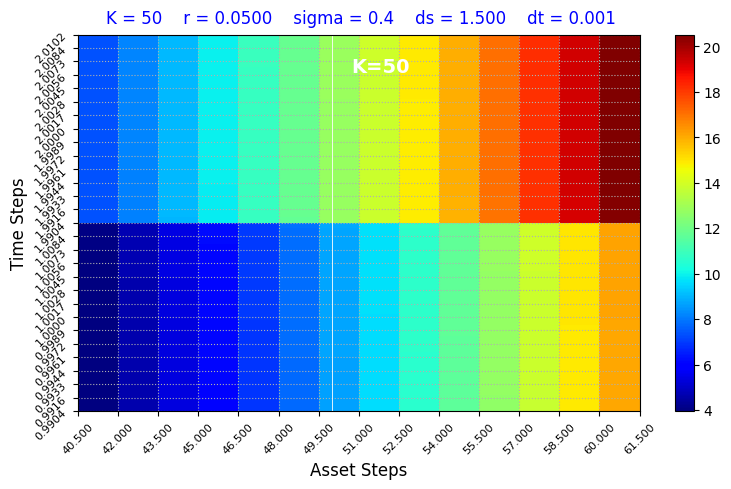

In [17]:
bsm_heatmap(df)

Max=45.0     6.145
46.5     6.957
48.0     7.817
49.5     8.722
51.0     9.671
52.5    10.660
54.0    11.688
55.5    12.753
dtype: float64


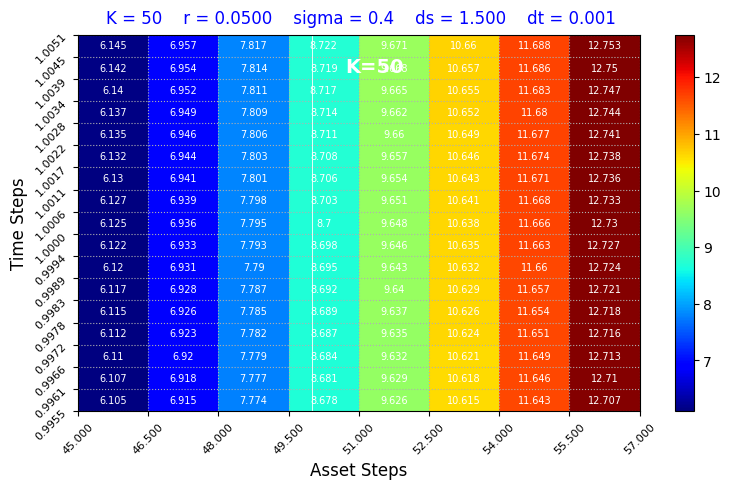

In [18]:
times = [t for t in data.index if 0.995<=t<=1.005]
prices = [s for s in data.keys() if 44<=s<=56]
df = data.loc[times,prices]
bsm_heatmap(df,vlabel=True)